# Predict size of cluster from text content

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.utils import shuffle

%matplotlib inline

In [60]:
# Creating features
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import lib.helper as helper

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

import spacy
nlp = spacy.load('en_core_web_sm')
from gensim.models.phrases import Phrases, Phraser

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
# Import various metrics by which to judge a model's performance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score              # Evaluate a model
from sklearn.metrics import f1_score                    # Evaluate a model
from sklearn.metrics import precision_score             # Evaluate a model
from sklearn.metrics import recall_score                # Evaluate a model

# Regression type measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import the ML models to try
from sklearn.ensemble import RandomForestRegressor

# Tools for evaluating the model by running it repeatedly with variants of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

In [62]:
def preprocess_desc(description):
    return( [stemmer.stem(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )


def get_phrased_nouns(sentences):
    """ Use spacy to get all of the actual entities, conjoin bigram nouns. """

    # Get the lists of nouns
    noun_lists = []
    for doc in sentences:
        parsed = nlp(doc)
        noun_lists.append([token.lemma_ for token in parsed if token.pos_ == 'PROPN'])

    # Build the phrase model
    phrases = Phrases(noun_lists, min_count=5, threshold=0.5)

    # Get the set of phrases present in the model
    results = []
    for nouns in noun_lists:
        results.append(phrases[nouns])

    return results

## 01.  Create features, labels, train-val-test split

In [92]:
# Load the corpus
df = pd.read_csv("working/RSS_clustered_louvain.csv")

# A quick utility function to pre-process the text
df["tokens"] = df["clean_text"].apply(preprocess_desc)
df['phrased_tokens'] = get_phrased_nouns(df['clean_text'])

# Create variable for cluster size
df_size = pd.DataFrame(df['cluster'].value_counts())
df_size['cluster_label'] = df_size.index
df_size.columns = ['cluster_size', 'cluster']
df_size.head()

df = df.merge(df_size, on="cluster", how="left")

df['cluster_size'] = np.where(df['cluster']==-1, 0.001, df['cluster_size'])

# Take a look at the features and labels
df[['cluster_size', 'tokens', 'phrased_tokens']]

,cluster_size,tokens,phrased_tokens
0,0.001,"[hurrican, dorian, lash, bahama, count, cost, ...","[Hurricane_Dorian, US_Bahamas, US_Bahamas]"
1,0.001,"[kohistan, video, murder, guilti, honour, kill...",[Kohistan]
2,0.001,"[mh, ukrain, plane, crash, key, wit, releas, u...","[MH17, Ukraine, MH17]"
3,0.001,"[articl, wed, ruin, kashmir, lockdown, indian,...","[Kashmir, Indian, Kashmir]"
4,863.000,"[syria, war, turkey, warn, europ, new, migrant...","[Syria_Turkey, Europe, President_Erdogan, Syria]"
...,...,...,...
31388,0.001,"[brit, woman, rape, park, stalk, predat, costa...","[park, a.m., Costa, Brava, Costa, Brava, Llore..."
31389,0.001,"[babi, girl, born, arm, leg, rare, genet, diso...","[India, BABY, India8217;s, Madhya_Pradesh, Sak..."
31390,0.001,"[coronaviru, second, wave, australia, forc, ro...","[Coronavirus_Australia, glimpse, Britain, HUND..."
31391,584.000,"[far, bank, england, predict, quick, econom, b...","[Bank_England, Quick, Economic, UK, GDP]"


In [93]:
vectorizer = TfidfVectorizer(decode_error="ignore",
                             max_features=5000)

# Create feature vectors
X = vectorizer.fit_transform(df['tokens'].apply(" ".join))

# Create Labels
y = np.asarray(np.log(df['cluster_size'].astype(float)))

# Check that worked
print(X.shape, y.shape)

# Split the data, save 'test' for final pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(31393, 5000) (31393,)


In [94]:
# Define the measurements we want to make
scoring = {'MSE': make_scorer(mean_squared_error),
           'MAE': make_scorer(mean_absolute_error)}

algo = RandomForestRegressor(n_estimators=50,
                             max_depth=10)

results = cross_validate(algo,
                         X_train,
                         y_train,
                         cv=10,
                         return_train_score=True,
                         return_estimator=True,
                         n_jobs=-1)

y_pred = cross_val_predict(algo, X_train, y_train, cv=10)

In [95]:
{key: np.mean(value) for key, value in results.items() if key != 'estimator'}

{'fit_time': 13.065126824378968,
 'score_time': 0.010094332695007324,
 'test_score': 0.21795299714359703,
 'train_score': 0.2998339672064332}

## Diagnostic training plots here

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


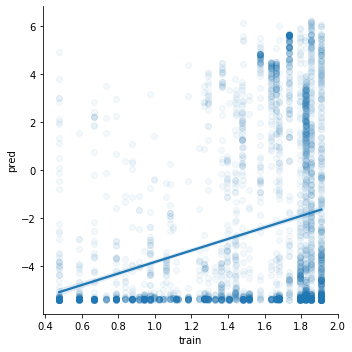

In [96]:
temp_df = pd.DataFrame({"train": np.log(y_train),
                        "pred": y_pred})

sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

## Examine features using simple linear regression

In [37]:
# Fit a traditional Linear Regression Model so that we can examine the p-values and r2 values
# of different features

import statsmodels.api as sm
from patsy import dmatrices

In [38]:
df_stats = pd.DataFrame(data=X_train.todense(), columns=list(vectorizer.get_feature_names()))
df_stats.head()

df_stats['StorySize'] = y_train

In [39]:
formula = "StorySize ~ " + " + ".join(vectorizer.get_feature_names())

y, X_explore = dmatrices(formula, data=df_stats, return_type='dataframe')

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
model = sm.OLS(y, X_explore)
results = model.fit()
print(results.summary())